In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


angry: 978 images
disgust: 547 images
fear: 1024 images
happy: 1586 images
neutral: 1253 images
sad: 1257 images
surprise: 831 images


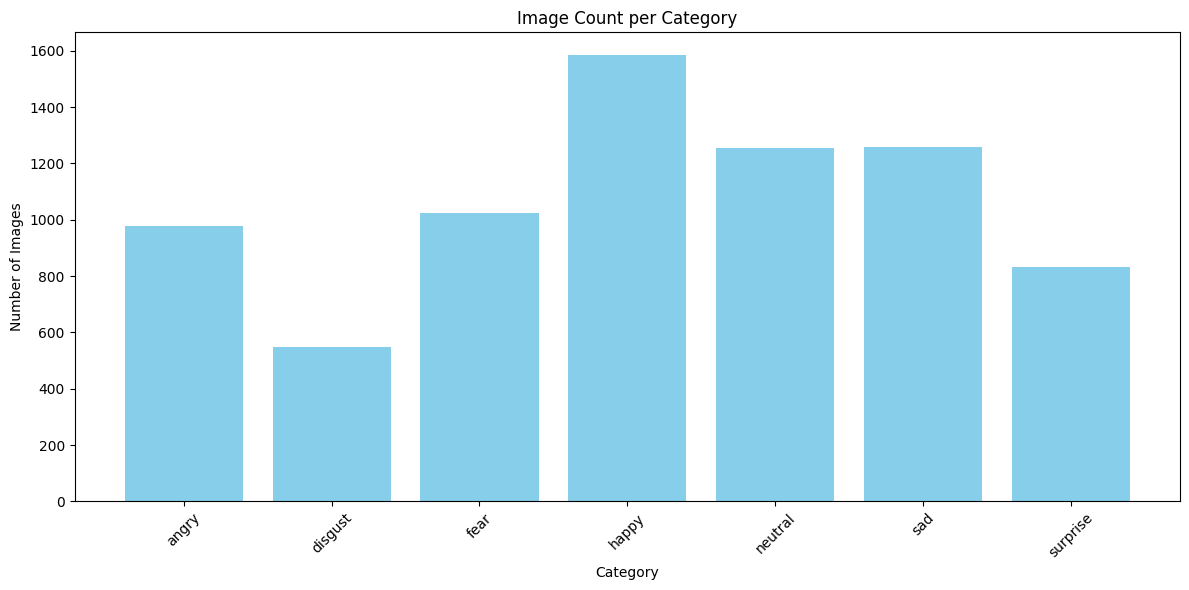

In [24]:
import os
import matplotlib.pyplot as plt

# Set dataset path
dataset_path = "/content/drive/MyDrive/NNDL project/data"

# List categories
categories = sorted(os.listdir(dataset_path))
image_counts = []

# Count images in each category
for category in categories:
    category_path = os.path.join(dataset_path, category)
    image_files = [f for f in os.listdir(category_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    image_counts.append(len(image_files))
    print(f"{category}: {len(image_files)} images")

# Plot bar chart
plt.figure(figsize=(12, 6))
plt.bar(categories, image_counts, color='skyblue')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.title('Image Count per Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [25]:
# Use Path object instead of string
from pathlib import Path
dataset_path = Path("/content/drive/MyDrive/NNDL project/data")

# Get class names (folder names)
classes = sorted(os.listdir(dataset_path))

# Initialize empty lists
images_list = []
labels_list = []


In [26]:
#Preprocessing of Image & Label List Creation

import os
import numpy as np
from PIL import Image
from pathlib import Path

# Loop through each class
for index, label in enumerate(classes):
    image_folder = dataset_path / label
    for image_path in image_folder.glob("*"):
        try:
            # Load image
            image = Image.open(image_path)

            # Convert to RGB if not already
            if image.mode != 'RGB':
                image = image.convert('RGB')

            # Resize to 128x128
            image = image.resize((128, 128))

            # Convert to numpy array and append
            images_list.append(np.array(image))
            labels_list.append(index)
        except Exception as e:
            print(f"Failed to process {image_path}: {e}")

print("Total Images:", len(images_list))
print("Total Labels:", len(labels_list))


Total Images: 7476
Total Labels: 7476


In [27]:
#  Use Path object instead of string
from pathlib import Path

# Get class names (folder names)
classes = sorted(os.listdir(dataset_path))

# Initialize empty lists
images_list = []
labels_list = []

In [28]:
# Preprocessing of Image & Label List Creation

# Use Path object instead of string
from pathlib import Path

# Iterate through each class directory
for class_index, class_name in enumerate(classes):
    class_dir = Path(dataset_path) / class_name  # Use Path object for directory

    # Iterate through each image in the class directory
    for image_name in os.listdir(class_dir):
        if image_name.lower().endswith(('.jpg', '.jpeg', '.png')):  # Check image extension
            image_path = str(class_dir / image_name) # Convert Path object back to string for image loading
            images_list.append(image_path)
            labels_list.append(class_index) # Assign class index as the label

print("Total Images:", len(images_list))
print("Total Labels:", len(labels_list))

Total Images: 7476
Total Labels: 7476


In [29]:
from PIL import Image

print("Type of images_list:", type(images_list))

# Load the first image using PIL to get its shape

image = Image.open(images_list[0])
print("Shape of image in images_list:", image.size) # Print the size (width, height)
print("Type of image in images_list:", type(images_list[0]))

Type of images_list: <class 'list'>
Shape of image in images_list: (48, 48)
Type of image in images_list: <class 'str'>


In [30]:
#Preprocessing of Image & Label List Convertion to NumPy Arrays
images_list = np.array(images_list)
labels_list = np.array(labels_list)

In [31]:
#Split Data to Train, Test & Validation
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(images_list, labels_list, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("X_val:", X_val.shape)
print("Pixel values of the first pixel (RGB) of image (BEFORE NORMALIZATION):", X_train[0][0][0])

X_train: (5233,)
X_test: (1122,)
X_val: (1121,)
Pixel values of the first pixel (RGB) of image (BEFORE NORMALIZATION): /


In [32]:
#Normalization
def normalize_image(image_path):
    img = Image.open(image_path)
    img_array = np.array(img)
    # Normalize pixel values to the range [0, 1]
    normalized_img = img_array / 255.0
    return normalized_img

# Example of how to use normalize_image function.
X_train_normalized = np.array([normalize_image(image_path) for image_path in X_train])
X_val_normalized = np.array([normalize_image(image_path) for image_path in X_val])
X_test_normalized = np.array([normalize_image(image_path) for image_path in X_test])

print("Shape of normalized X_train:", X_train_normalized.shape)
print("Pixel values of the first pixel (RGB) of image (AFTER NORMALIZATION):", X_train_normalized[0][0][0])

Shape of normalized X_train: (5233, 48, 48)
Pixel values of the first pixel (RGB) of image (AFTER NORMALIZATION): 0.43529411764705883


In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the ImageDataGenerator for training
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values
    rotation_range=30,
    shear_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2         # Split for validation
)

# Train generator
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(64, 64),
    batch_size=16,
    class_mode='sparse',
    subset='training',
    shuffle=True
)

# Validation generator
val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(64, 64),
    batch_size=16,
    class_mode='sparse',
    subset='validation',
    shuffle=False
)

Found 5984 images belonging to 7 classes.
Found 1492 images belonging to 7 classes.


In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming your images are grayscale, add a channel dimension
X_test_normalized = X_test_normalized.reshape(X_test_normalized.shape[0], X_test_normalized.shape[1], X_test_normalized.shape[2], 1)

# Create an ImageDataGenerator instance for test data
test_augmentations = ImageDataGenerator(rescale=1./255)  # You might want to add other augmentations if needed

# Create the test generator
test_generator = test_augmentations.flow(
    X_test_normalized,
    y_test,
    batch_size=16,
    shuffle=False
)

(64, 64, 3)


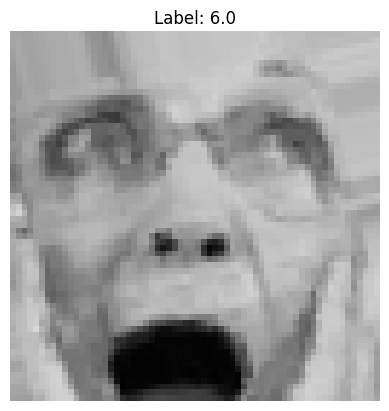

In [35]:
# Take the first image batch and the labels from train generator
images_batch, labels_batch = next(train_generator)
# Take the first image from the batch
image_to_preview = images_batch[0]

print(image_to_preview.shape)
# Display the image
plt.imshow(image_to_preview)
plt.title(f"Label: {labels_batch[0]}")
plt.axis('off')
plt.show()

In [36]:
#Callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
early_stopping = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)

In [37]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

**MoodCNN** model


In [62]:
# prompt: build moodCNN model for this dataset

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the MoodCNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Add dropout for regularization
    Dense(len(categories), activation='softmax') # Output layer with softmax
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy for integer labels
              metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(
    train_generator,
    epochs=60,  # Adjust the number of epochs
    validation_data=val_generator,
    callbacks=[early_stopping, lr_scheduler]
)




/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,103 (2.61 MB)

 Trainable params: 684,103 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
374/374 ━━━━━━━━━━━━━━━━━━━━ 36s 89ms/step - accuracy: 0.1985 - loss: 1.9288 - val_accuracy: 0.2118 - val_loss: 1.8894 - learning_rate: 0.0010
Epoch 2/40
374/374 ━━━━━━━━━━━━━━━━━━━━ 32s 86ms/step - accuracy: 0.2151 - loss: 1.9042 - val_accuracy: 0.2232 - val_loss: 1.8915 - learning_rate: 0.0010
Epoch 3/40
374/374 ━━━━━━━━━━━━━━━━━━━━ 33s 87ms/step - accuracy: 0.2261 - loss: 1.8805 - val_accuracy: 0.2359 - val_loss: 1.8623 - learning_rate: 0.0010
Epoch 4/40
374/374 ━━━━━━━━━━━━━━━━━━━━ 32s 86ms/step - accuracy: 0.2377 - loss: 1.8633 - val_accuracy: 0.2547 - val_loss: 1.8384 - learning_rate: 0.0010
Epoch 5/40
374/374 ━━━━━━━━━━━━━━━━━━━━ 41s 85ms/step - accuracy: 0.2397 - loss: 1.8537 - val_accuracy: 0.2547 - val_loss: 1.8261 - learning_rate: 0.0010
Epoch 6/40
374/374 ━━━━━━━━━━━━━━━━━━━━ 36s 97ms/step - accuracy: 0.2552 - loss: 1.8348 - val_accuracy: 0.2574 - val_loss: 1.8184 - learning_rate: 0.0010
Epoch 7/40
374/374 ━━━━━━━━━━━━━━━━━━━━ 36s 97ms/step - accuracy: 0.2479 - l

In [63]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming your images are grayscale, add a channel dimension
#X_test_normalized = X_test_normalized.reshape(X_test_normalized.shape[0], X_test_normalized.shape[1], X_test_normalized.shape[2], 1)
# Create an ImageDataGenerator instance for test data
test_augmentations = ImageDataGenerator(rescale=1./255)  # You might want to add other augmentations if needed

# Create the test generator
test_generator = test_augmentations.flow_from_directory(
    dataset_path,
    target_size=(64, 64), # This should match the input shape of your model
    batch_size=16,
    class_mode='sparse',
    shuffle=False,
    # color_mode='rgb'  # Explicitly load images in RGB format
)

Found 7476 images belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Test Loss: 1.2855
Test Accuracy: 0.5189


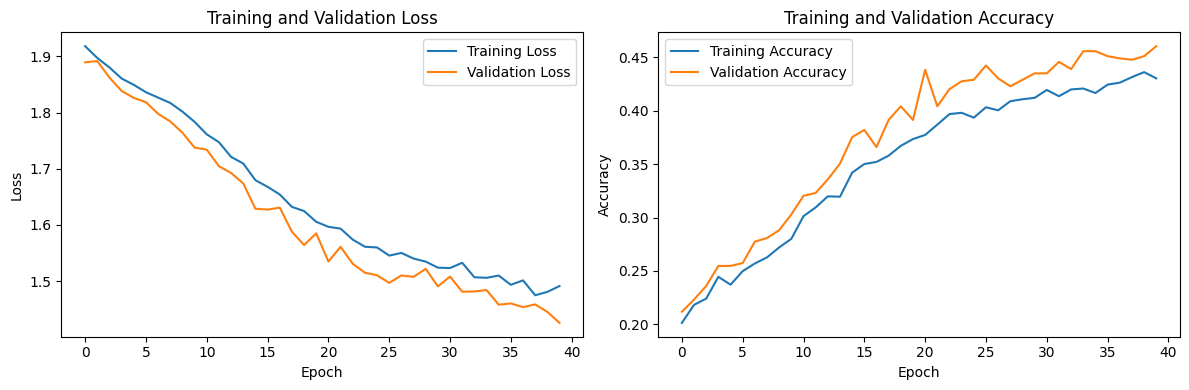

468/468 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step


In [64]:
# prompt: evaluation

# Evaluate the model
loss, accuracy = model.evaluate(test_generator, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

# Make predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)


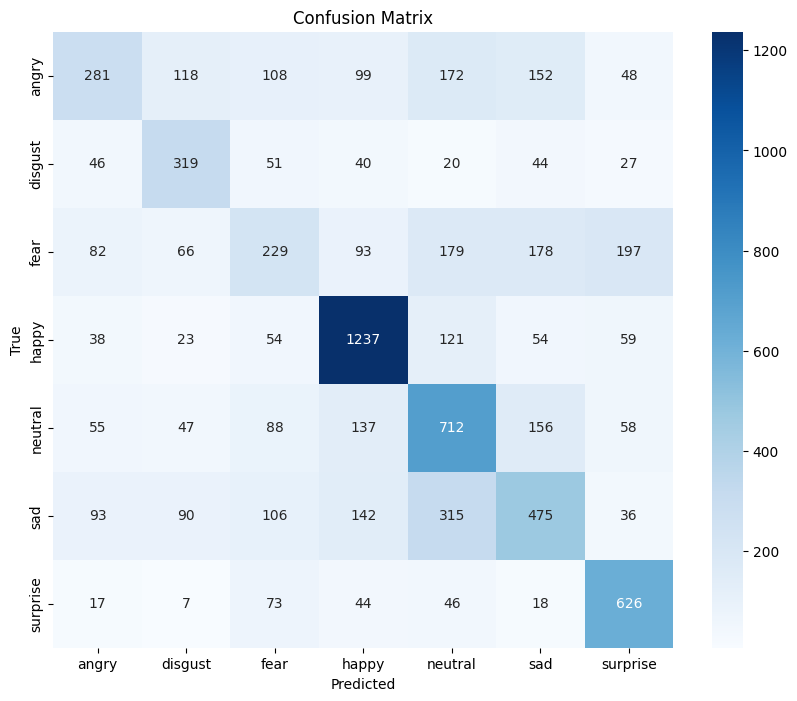

In [65]:
# In the cell where you compute and plot the confusion matrix (ipython-input-56-68e23739e6d8):
# Replace the following line:
# cm = confusion_matrix(y_test, y_pred_classes)

# with the following code block:
import numpy as np

# Get the true labels for the images in the test_generator
y_true_test_generator = test_generator.classes

# Reshape y_pred_classes to match the length of y_true_test_generator
y_pred_classes_reshaped = y_pred_classes[:len(y_true_test_generator)]

# Now calculate the confusion matrix
cm = confusion_matrix(y_true_test_generator, y_pred_classes_reshaped)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=categories, yticklabels=categories)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


468/468 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step


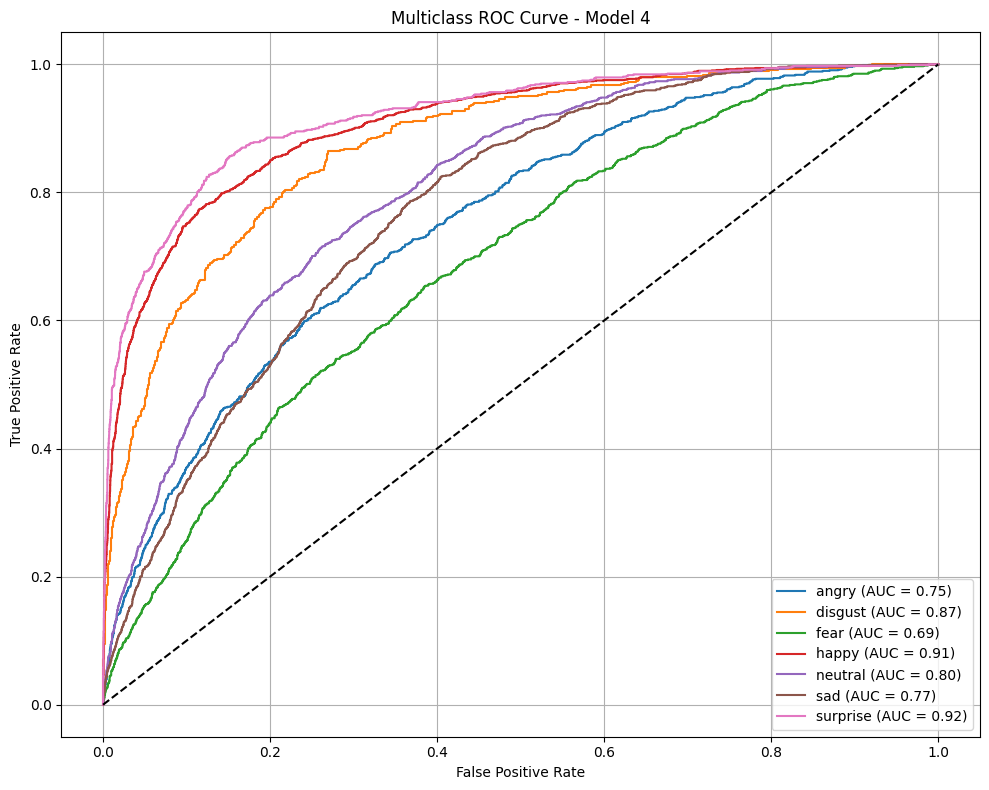

In [61]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import LabelBinarizer

# Assuming 'model' is your trained model and 'test_generator' is your test data generator
y_pred_probs = model.predict(test_generator)  # Get predicted probabilities

# Instead of using argmax to get predicted class labels, keep probabilities
# y_pred_4 = np.argmax(y_pred_probs, axis=1)  # Get predicted class labels
y_pred_4 = y_pred_probs # Assign y_pred_probs to y_pred_4

# Get the true labels for the images in the test_generator
y_true_test_generator = test_generator.classes

# Binarize the true labels from the generator
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_true_test_generator)

# If only 1 output (binary), fix shape
if y_test_bin.shape[1] == 1:
    y_test_bin = np.hstack((1 - y_test_bin, y_test_bin))

# Reshape predicted probabilities to match the length of true labels if necessary
y_pred_4 = y_pred_4[:len(y_true_test_generator)]

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_4[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.title('Multiclass ROC Curve - Model 4')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()